SSD, ONNX model, ORT Inferencing


Install required packages.
Pandas is deprecated due to an older version used later on in `open_images_downloader.py`.

In [ ]:
!pip install onnx onnxruntime boto3 pandas==1.5

ERROR: Ignored the following versions that require a different python version: 1.4.0 Requires-Python >=3.8; 1.4.0rc0 Requires-Python >=3.8; 1.4.1 Requires-Python >=3.8; 1.4.2 Requires-Python >=3.8; 1.4.3 Requires-Python >=3.8; 1.4.4 Requires-Python >=3.8; 1.5.0 Requires-Python >=3.8; 1.5.0rc0 Requires-Python >=3.8; 1.5.1 Requires-Python >=3.8; 1.5.2 Requires-Python >=3.8; 1.5.3 Requires-Python >=3.8; 2.0.0 Requires-Python >=3.8; 2.0.0rc0 Requires-Python >=3.8; 2.0.0rc1 Requires-Python >=3.8; 2.0.1 Requires-Python >=3.8; 2.0.2 Requires-Python >=3.8; 2.0.3 Requires-Python >=3.8; 2.1.0 Requires-Python >=3.9; 2.1.0rc0 Requires-Python >=3.9; 2.1.1 Requires-Python >=3.9; 2.1.2 Requires-Python >=3.9; 2.1.3 Requires-Python >=3.9; 2.1.4 Requires-Python >=3.9; 2.2.0 Requires-Python >=3.9; 2.2.0rc0 Requires-Python >=3.9; 2.2.1 Requires-Python >=3.9; 2.2.2 Requires-Python >=3.9; 2.2.3 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement pandas==1.5 (from versions: 0

## Finetune MobileNetV1-SSD

First, you can clone this GitHub repository: https://github.com/qfgaohao/pytorch-ssd using the git clone command.

In [ ]:
!git clone https://github.com/qfgaohao/pytorch-ssd.git

Cloning into 'pytorch-ssd'...
remote: Enumerating objects: 819, done.
remote: Total 819 (delta 0), reused 0 (delta 0), pack-reused 819 (from 1)
Receiving objects: 100% (819/819), 1.05 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (549/549), done.


Navigate to cloned repo.

In [ ]:
%cd pytorch-ssd

/home/jupyter/pytorch-ssd


**Download the model and save it under /models**

In [ ]:
!wget -P data/ -c http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

--2024-11-02 04:44:15--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘data/VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>] 430.13M  32.2MB/s    in 14s     

2024-11-02 04:44:29 (30.3 MB/s) - ‘data/VOCtest_06-Nov-2007.tar’ saved [451020800/451020800]



In [ ]:
!tar -xf data/VOCtest_06-Nov-2007.tar -C data/

In [ ]:
!python eval_ssd.py --net mb1-ssd \
                    --trained_model models/mobilenet-v1-ssd-mp-0_675.pth \
                    --dataset_type voc \
                    --dataset data/VOCdevkit/VOC2007 \
                    --label_file models/voc-model-labels.txt

**Download Open-Images Data. Choose your classes, for example: "Aircraft, Aeroplane", "Handgun,Shotgun", etc.**

In [ ]:
!python open_images_downloader.py --root open_images --class_names Handgun,Shotgun --num_workers 20

**Fine-tune a MobilNet-V1-SSD model on Open-Images using the following https://github.com/qfgaohao/pytorch-ssd?tab=readme-ov-file#retrain.
You may need to download the checkpoint first in order to run this script.**

The following chnage was wade in train_ssd.py to get the prefinetuned model weights.

    model_path = os.path.join(args.checkpoint_folder, f"{args.net}-open-images-pre-finetuned.pth")
    net.save(model_path)
    logging.info(f"Saved pre-finetuned model {model_path}")
    logging.info(f"Start training from epoch {last_epoch + 1}.")
    for epoch in range(last_epoch + 1, args.num_epochs):

In [ ]:
!python train_ssd.py --dataset_type open_images\
                     --datasets open_images\
                     --net mb1-ssd\
                     --pretrained_ssd models/mobilenet-v1-ssd-mp-0_675.pth\
                     --scheduler cosine\
                     --lr 0.01\
                     --t_max 100\
                     --validation_epochs 5\
                     --base_net_lr 0.001\
                     --batch_size 5


In [ ]:
# Compute the accuracy of the test data for these categories before and after finetuning

**Calculate precision of the finetuned model**

In [ ]:
!python eval_ssd.py --net mb1-ssd \
                    --trained_model models/mb1-ssd-Epoch-119-Loss-2.7013489246368407.pth \
                    --dataset_type open_images \
                    --dataset open_images \
                    --label_file models/open-images-model-labels.txt

**Calculate the precision before finetuning**

In [ ]:
!python eval_ssd.py --net mb1-ssd \
                    --trained_model models/mb1-ssd-open-images-pre-finetuned.pth \
                    --dataset_type open_images \
                    --dataset open_images \
                    --label_file models/open-images-model-labels.txt

#### Before Finetuning
**Average Precision Per-class:**

Handgun: 0.036786531787305676

Shotgun: 0.004306407698651732

***Average Precision Across All Classes:*** 0.020546469742978704

#### After Finetuning
**Average Precision Per-class:**

Handgun: 0.8297812742218196

Shotgun: 0.5788907557666659

***Average Precision Across All Classes:*** 0.7043360149942428


**We can see a significant impovement in precision after finetuning.**

In [ ]:
# load your finetuned model after being saved in script
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd
create_net = create_mobilenetv1_ssd
net = create_mobilenetv1_ssd(3)
net.load('models/mb1-ssd-Epoch-119-Loss-2.7013489246368407.pth')
net.eval()

## Export the Pytorch model to ONNX

In [ ]:
import torch.onnx

dummy_tensor = torch.randn(1, 3, 300, 300) # according to input shape for SSD
torch.onnx.export(net, dummy_tensor, "model.onnx")

**The following steps are done using the tutorial: https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html**

## Load and verify saved model

In [ ]:
import onnx

# Load onnx model
onnx_model = onnx.load('model.onnx')

# Check onnx model
try:
    onnx.checker.check_model(onnx_model)
    print("ONNX model is valid and verified successfully.")
except onnx.checker.ValidationError as e:
    print(f"ONNX model validation error: {e}")


ONNX model is valid and verified successfully.


## Run with ONNX Runtime

In [ ]:
!pip install onnxruntime

In [ ]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession('model.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_tensor)}
ort_outs = ort_session.run(None, ort_inputs)

print("Model outputs: ", ort_outs)

Model outputs:  [array([[[ 4.138952  , -2.2944212 , -2.216733  ],
        [ 4.2343516 , -2.302606  , -2.0582252 ],
        [ 4.244662  , -1.9096256 , -2.3481529 ],
        ...,
        [ 0.01250033,  1.8875859 , -1.4585828 ],
        [ 0.31281197,  1.5629544 , -1.9227388 ],
        [ 0.33774388,  1.4160821 , -1.9902153 ]]], dtype=float32), array([[[ 0.9882157 ,  1.0734305 , -3.1730447 , -4.102948  ],
        [-0.18368417,  0.5290229 , -0.536974  , -0.19406721],
        [ 1.300414  ,  0.46889022, -4.1472974 , -3.0854743 ],
        ...,
        [-0.04928746, -0.09952645,  1.9342688 , -0.18478058],
        [-0.0276783 , -0.18623476, -0.0289406 ,  3.1561136 ],
        [-0.0441659 , -0.01642198,  3.0622752 , -0.07036533]]],
      dtype=float32)]


## Matching Pytorch with ONNX Runtime

In [ ]:
import numpy as np

# Compare ONNX Runtime and PyTorch results
torch_out = net(dummy_tensor)
np.testing.assert_allclose(to_numpy(torch_out[0]), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")


Exported model has been tested with ONNXRuntime, and the result looks good!


### Precision Used for Comparison

- **Relative tolerance (`rtol`)**: `1e-03` (or 0.001)
- **Absolute tolerance (`atol`)**: `1e-05` (or 0.00001)


## Test Inference

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import onnxruntime as ort
import numpy as np

# Load an image from each category
shotgun_image_path = 'open_images/test/0f5eec3235d8a3df.jpg'
handgun_image_path = 'open_images/test/04abf880fdee279d.jpg'
handgun_image = Image.open(handgun_image_path)
shotgun_image = Image.open(shotgun_image_path)

# Define image transformations (resize, center crop, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to model input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

#First checking it for handgun

image = handgun_image
# Apply transformations to the image
image_tensor = transform(image)

# Add a batch dimension (since the model expects a batch of images)
image_tensor = image_tensor.unsqueeze(0)

# Convert to NumPy array and ensure it is in float32 format
image_numpy = image_tensor.numpy().astype(np.float32)

# Load the ONNX model and create a session
ort_session = ort.InferenceSession('model.onnx')

# Prepare the input for ONNX Runtime
ort_inputs = {ort_session.get_inputs()[0].name: image_numpy}

# Run inference with ONNX Runtime
ort_outs = ort_session.run(None, ort_inputs)

# Display the output
print("Inference output for handgun:", ort_outs)


Inference output for handgun: [array([[[ 4.2155313, -2.621729 , -1.642407 ],
        [ 4.1980786, -2.7049193, -1.7645396],
        [ 3.9407806, -2.565371 , -1.5978413],
        ...,
        [-1.0686209,  4.0928397, -1.8971887],
        [-3.105978 ,  4.59342  , -1.5126034],
        [ 1.6724393,  1.9223405, -3.4866023]]], dtype=float32), array([[[ 0.7583571 ,  0.6814259 , -2.0037158 , -3.0193138 ],
        [ 0.42989814,  0.09813422, -0.31730378, -0.9580354 ],
        [ 1.4338768 ,  0.33157706, -2.3778656 , -2.6814122 ],
        ...,
        [ 0.5498892 , -0.51993597,  1.5797917 , -1.4312067 ],
        [ 0.3467882 , -1.0255072 , -0.42936343,  1.6362664 ],
        [ 0.70817363, -0.37776214,  2.653632  , -1.225887  ]]],
      dtype=float32)]


In [ ]:
for i, output in enumerate(ort_outs):
    print(f"Shape of output {i}: {output.shape}")


Shape of output 0: (1, 3000, 3)
Shape of output 1: (1, 3000, 4)


In [ ]:
#Now, checking it for shotgun

image2 = shotgun_image
# Apply transformations to the image
image_tensor2 = transform(image2)

# Add a batch dimension (since the model expects a batch of images)
image_tensor2 = image_tensor2.unsqueeze(0)

# Convert to NumPy array and ensure it is in float32 format
image_numpy2 = image_tensor2.numpy().astype(np.float32)

# Load the ONNX model and create a session
ort_session = ort.InferenceSession('model.onnx')

# Prepare the input for ONNX Runtime
ort_inputs = {ort_session.get_inputs()[0].name: image_numpy2}

# Run inference with ONNX Runtime
ort_outs = ort_session.run(None, ort_inputs)

# Display the output
print("Inference output for shotgun:", ort_outs)

Inference output for shotgun: [array([[[ 4.0262017 , -2.0800803 , -2.327384  ],
        [ 4.0786734 , -2.061006  , -2.1991742 ],
        [ 4.3765    , -2.1505277 , -2.2689002 ],
        ...,
        [-2.0272765 ,  0.10462422,  1.7820004 ],
        [-1.161845  , -0.02562113,  1.3632349 ],
        [-1.0672823 , -0.17684731,  1.2257465 ]]], dtype=float32), array([[[ 0.7416128 ,  0.8573649 , -2.6064224 , -2.9544332 ],
        [ 0.27940652,  0.0068048 , -0.7956439 , -0.69483036],
        [ 1.3686033 ,  0.06846011, -3.1729958 , -2.7066936 ],
        ...,
        [ 0.0416701 , -0.00749676,  1.8828206 , -0.14421996],
        [ 0.01597861, -0.0140432 , -0.04223498,  2.7433546 ],
        [ 0.06386144, -0.01530605,  2.8264883 , -0.13280994]]],
      dtype=float32)]


In [ ]:
for i, output in enumerate(ort_outs):
    print(f"Shape of output {i}: {output.shape}")


Shape of output 0: (1, 3000, 3)
Shape of output 1: (1, 3000, 4)


## Parse and show outputs

**Refer to the code in https://github.com/qfgaohao/pytorch-ssd/blob/master/run_ssd_example.py to show inference outputs.**

In [ ]:
import vision.utils.box_utils_numpy as box_utils
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


def predict(width, height, ort_outputs, prob_threshold, iou_threshold=0.5, top_k=-1):
    # Assuming ort_outputs is a tuple of (confidences, boxes)
    confidences, boxes = ort_outputs

    boxes = boxes[0]  # Get the first batch of boxes
    confidences = confidences[0]  # Get the first batch of confidences

    picked_box_probs = []
    picked_labels = []

    for class_index in range(1, confidences.shape[1]):  # Starting from 1 to skip background
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)

        # Here you need to adjust to ensure the NMS function handles the box probabilities correctly
        box_probs = box_utils.hard_nms(box_probs,
                                        iou_threshold=iou_threshold,
                                        top_k=top_k)

        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])

    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])

    picked_box_probs = np.concatenate(picked_box_probs)

    # Scale bounding boxes back to original image dimensions
    picked_box_probs[:, 0] *= width  # x1
    picked_box_probs[:, 1] *= height  # y1
    picked_box_probs[:, 2] *= width  # x2
    picked_box_probs[:, 3] *= height  # y2

    return picked_box_probs[:, :4].astype(np.int32), np.array(picked_labels), picked_box_probs[:, 4]

def draw_boxes_with_pil(image_path, boxes, labels, scores):
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 1000)
    except IOError:
        font = ImageFont.load_default()

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.astype(int)

        # Ensure bounding box coordinates are valid
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.width, x2)
        y2 = min(image.height, y2)

        # Check if the coordinates are still valid
        if x2 >= x1 and y2 >= y1:
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            label_text = f'Class {label}: {score:.2f}'
            draw.text((x1, y1), label_text, fill="red", font=font)

    # Show the image
    plt.imshow(np.array(image))
    plt.axis('off')  # Hide axes
    plt.show()


prob_threshold = 0.0  # Confidence threshold is positive
iou_threshold = 0.1   # IOU threshold for NMS


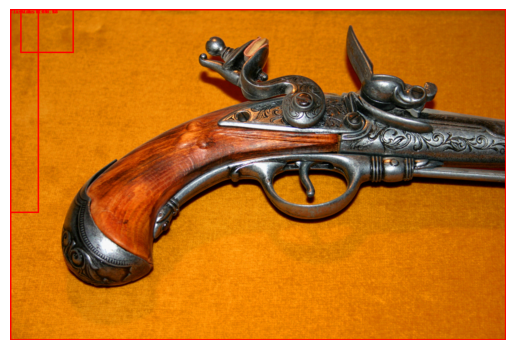

In [ ]:
# Parsing output and showing the bounding boxes for handgun
height, width = image.size

# Run prediction to get bounding boxes, labels, and scores
boxes, labels, scores = predict(width, height, ort_outs, prob_threshold, iou_threshold)

# Draw boxes on the image
draw_boxes_with_pil(handgun_image_path, boxes, labels, scores)

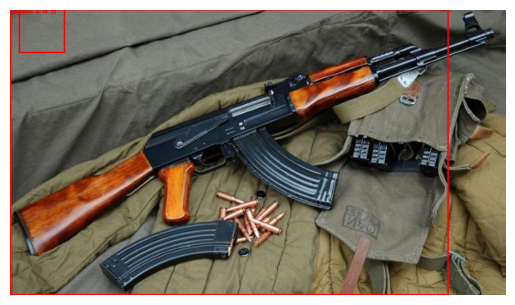

In [ ]:
# Parsing output and showing the bounding boxes for shotgun
height, width = image2.size

# Run prediction to get bounding boxes, labels, and scores
boxes, labels, scores = predict(width, height, ort_outs, prob_threshold, iou_threshold)

# Draw boxes on the image
draw_boxes_with_pil(shotgun_image_path, boxes, labels, scores)